# Planaria Velocyto Analysis: Epidermis

This is based on the Velocyto [La Manno *et al.*]() analysis of [Plass *et al.*]().

In [1]:
import sys
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import loompy
import velocyto as vcy
import pandas as pd
import scanpy.api as sc

from IPython.core.display import display, HTML
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [2]:
dirr='./data/'
vlm = vcy.VelocytoLoom(dirr+"all_sgete_4GU75.loom")
ds = loompy.connect(dirr+"all_sgete_4GU75.loom")

In [3]:
### Get the velocyto cell barcodes
velo_list = [x[16:29] for x in list(vlm.ca["CellID"])]

### Get seurat cells and annotation
base_dir = "./data/"
file = "Planaria_Seurat_annot.csv"
annotation = pd.read_csv(base_dir+file, delimiter=',', index_col=0)
#tsneCoord = pd.read_csv(base_dir+"tsneCoordinates.csv", delimiter=',', index_col=0)
#annotation = pd.merge(annotation, tsneCoord, left_index=True, right_index=True)
annotation = annotation.set_index('New_CBC')
annotation = annotation.loc[velo_list]
color_dict = dict(zip(list(annotation["final_Id"].value_counts().index), list(annotation["col_hex"].value_counts().index)))

# add cluster, color and time as annotation from Seurat object to velocyto object
vlm.set_clusters(cluster_labels=list(np.array(annotation["final_Id"])), cluster_colors_dict=color_dict)
vlm.ca["Clusters"] = vlm.cluster_ix
vlm.ca["time"] = np.array(annotation["time"])
vlm.ca["final_Id"] = np.array(annotation["final_Id"])

In [4]:
def match_anndata_with_loom(filename_h5ad='./write/planaria_pp_extended.h5ad', filename_loom='./data/all_sgete_4GU75.loom'):
    adata = sc.read(filename_h5ad)

    ds = loompy.connect(filename_loom)
    loom_cells = [x[16:29] for x in ds.ca['CellID']]
    annotation = pd.read_csv('./data/Planaria_Seurat_annot.csv', delimiter=',', index_col=0)

    annotation = annotation.loc[adata.obs_names]    
    adata.obs_names = annotation['New_CBC']
    loom_cells = [x for x in loom_cells if x in adata.obs_names]
    adata = adata[loom_cells]
    # adata.obs_names = list(ds.ca['CellID']) # restore the cell names of the loom file in AnnData
    adata.write(filename_h5ad.replace('.h5ad', '_loom.h5ad'))
    
match_anndata_with_loom('./write/planaria_pp_extended_epidermis.h5ad')

In [5]:
adata = sc.read('./write/planaria_pp_extended_epidermis_loom.h5ad')

In [6]:
vlm.ts = adata.obsm['X_umap']

In [7]:
epidermal_clusters = [
    'epidermal neoblasts',
    'early epidermal progenitors',
    'late epidermal progenitors 1',
    'late epidermal progenitors 2', 'epidermis']

In [8]:
vlm.filter_cells(np.isin(vlm.ca["final_Id"], epidermal_clusters))

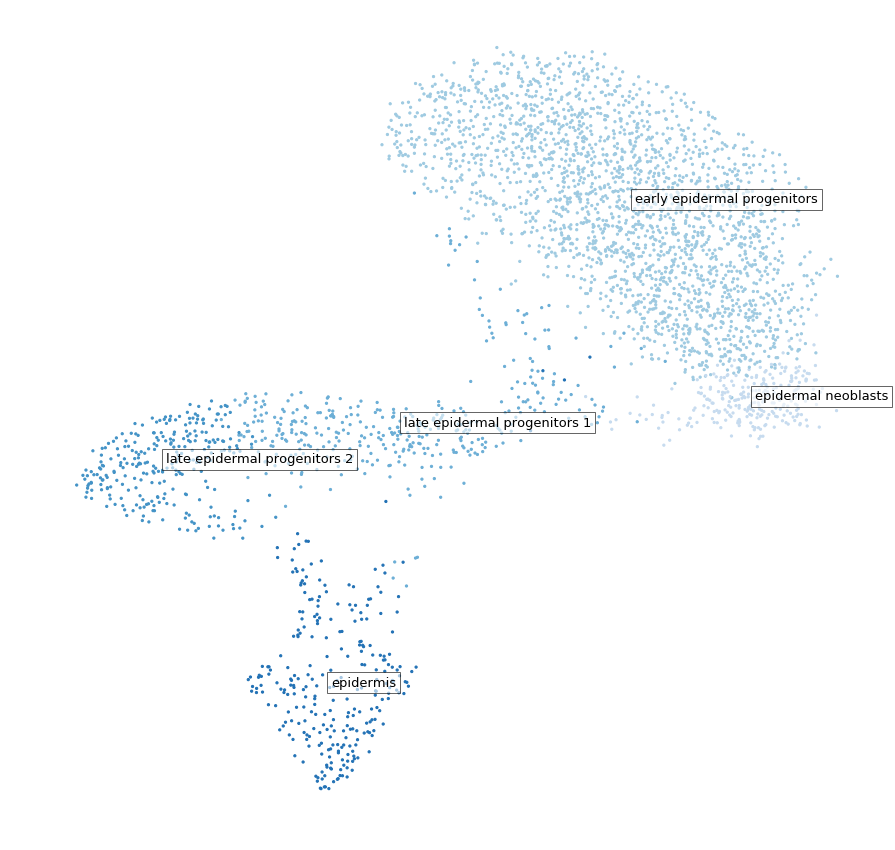

In [9]:
plt.figure(figsize=(15,15))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=5)
for cluster in np.unique(vlm.ca["final_Id"]):
    ts_m = np.median(vlm.ts[vlm.ca["final_Id"] == cluster, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["final_Id"] == cluster][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

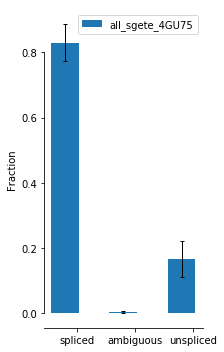

In [10]:
vlm.plot_fractions()

### Filtering genes

In [11]:
vlm.normalize("S", size=True,  log=False)
vlm.normalize("U", size=True,  log=False)

4003


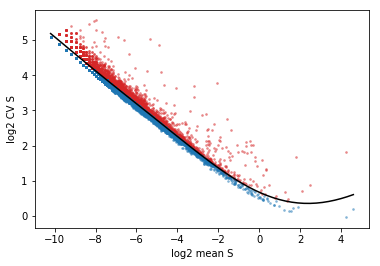

In [12]:
vlm.score_cv_vs_mean(4000, plot=True, max_expr_avg=35)
print(sum(vlm.cv_mean_selected))
vlm.filter_genes(by_cv_vs_mean=True)

In [13]:
vlm.score_detection_levels(min_expr_counts=3, min_cells_express=3, min_expr_counts_U=3, min_cells_express_U=3)
vlm.filter_genes(by_detection_levels=True)
print("Number of genes to be used:",vlm.S.shape[0])

Number of genes to be used: 2789


### Normalization, Dimension Reduction, Imputation

In [14]:
vlm.normalize_by_total()

number of PCs to be used: 82


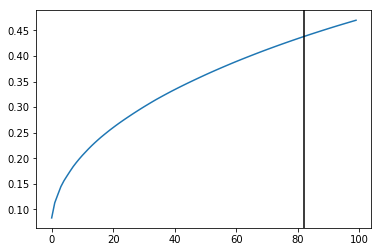

In [15]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print("number of PCs to be used:",n_comps)

In [16]:
k = 200
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4)

### Fitting gene steady states, Calculating velocity, transition probability

In [17]:
vlm.normalize_median()
vlm.fit_gammas(limit_gamma=True)

In [18]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1)

### Fit the velocyto transition matrix

In [19]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", n_neighbors=1000, knn_random=True, sampled_fraction=1)

### Plot on embedding with individual arrows

In [20]:
vlm.calculate_embedding_shift(sigma_corr = 0.02)

In [21]:
np.save('./write/vlm_transition_prob_epidermis.npy', vlm.transition_prob)

In [22]:
np.save('./write/vlm_delta_embedding_epidermis.npy', vlm.delta_embedding)

(-8.0906167716201285,
 5.9139372522803475,
 -4.0870554688704841,
 15.309048816768399)

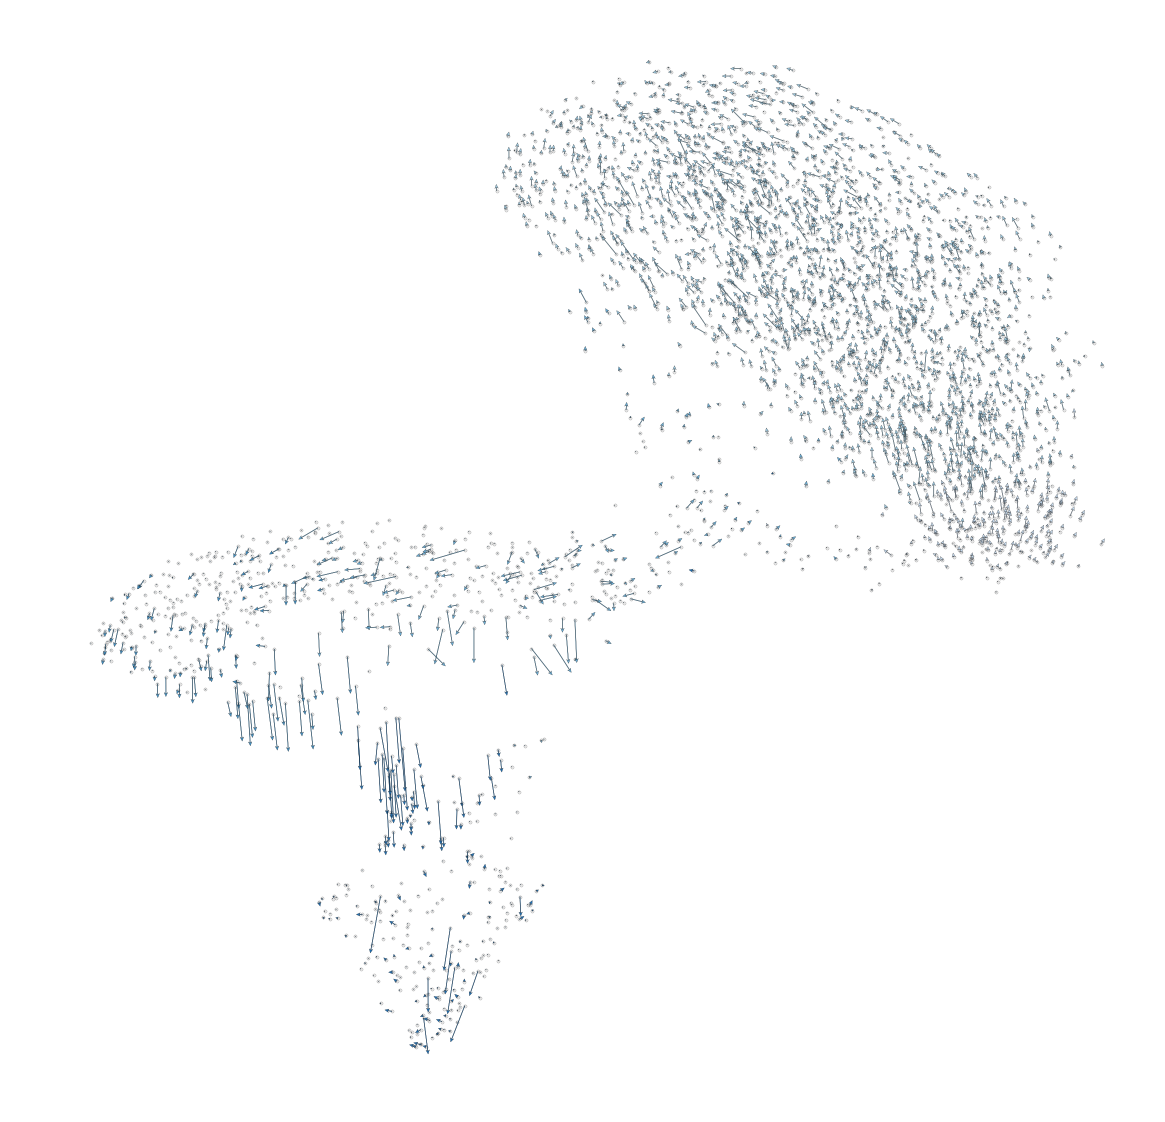

In [23]:
fig = plt.figure(None,(20,20))
quiver_scale = 1

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3)

quiver_kwargs=dict(headaxislength=6, headlength=8, headwidth=7,linewidths=0.2, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")